In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from battleship.board import Board
from battleship.agents import CodeQuestion, Question, EIGCalculator
from battleship.game import BattleshipGame
from battleship.captains import create_captain
from battleship.spotters import create_spotter
from battleship.fast_sampler import FastSampler

In [34]:
import logging

# logging.basicConfig(level=logging.DEBUG)


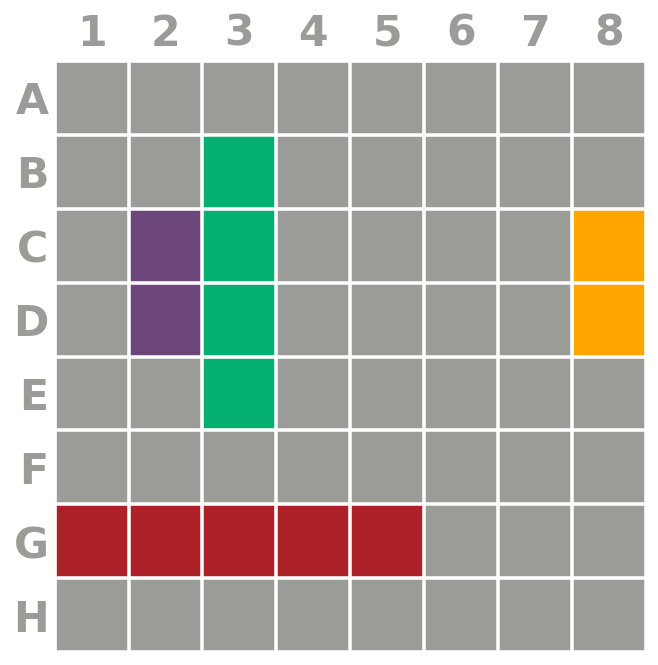

In [35]:
BOARD_ID = "B03"
SEED = 123

true_board = Board.from_trial_id(BOARD_ID)
true_board

In [36]:
def heatmap(board: Board, n_samples: int = 10000, constraints: list = []):
    sampler = FastSampler(
        board, ship_lengths=Board.SHIP_LENGTHS, ship_labels=Board.SHIP_LABELS, seed=SEED
    )
    # Compute posterior (return raw counts)
    posterior = sampler.compute_posterior(n_samples=n_samples, normalize=False, constraints=constraints)
    return Board._to_figure(posterior, mode="heatmap")

In [48]:
spotter = create_spotter(
    spotter_type="CodeSpotterModel",
    board_id=BOARD_ID,
    board_experiment="collaborative",
    llm="gpt-5",
    use_cot=True,
    json_path=None,
)

captain = create_captain(
    captain_type="MAPEIGCaptain_cot",
    seed=SEED,
    llm="gpt-5",
    board_id=BOARD_ID,
    map_samples=1000,
    prob_q_prob=None,
    eig_samples=1000,
    eig_k=10,
    json_path=None,
)

game = BattleshipGame(
    board_target=true_board,
    captain=captain,
    spotter=spotter,
)

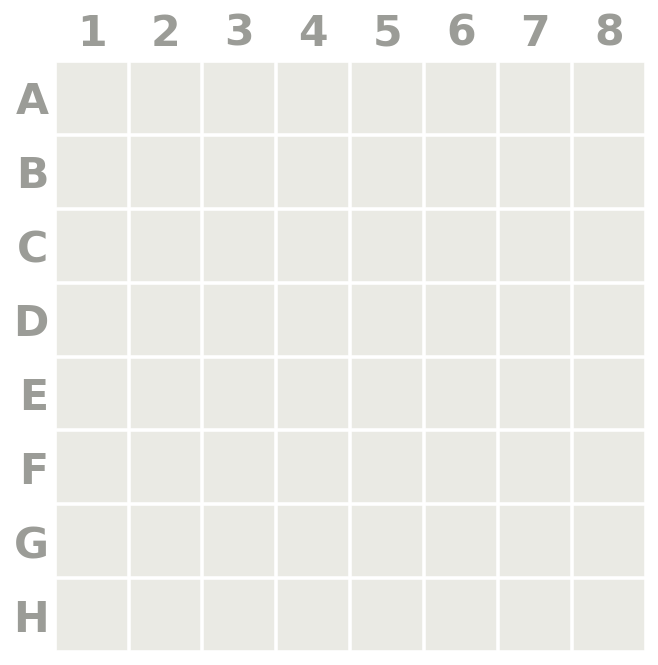

In [49]:
game

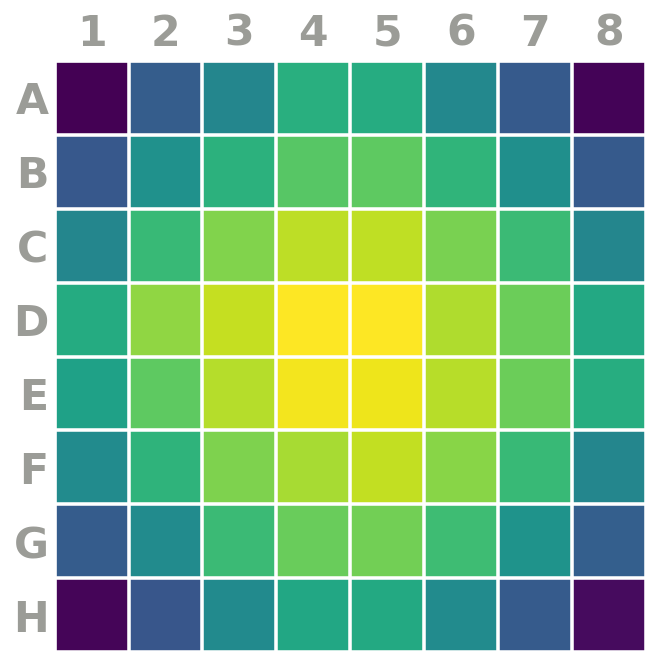

In [50]:
heatmap(game.state)

In [51]:
import numpy as np

def estimate_map_hit_probabilty(state: Board, n_samples: int = 10000, constraints: list = []) -> tuple[tuple[int, int], float]:
    sampler = FastSampler(
        state, ship_lengths=Board.SHIP_LENGTHS, ship_labels=Board.SHIP_LABELS, seed=SEED
    )
    # Compute posterior (return raw counts)
    posterior = sampler.compute_posterior(
        n_samples=n_samples, normalize=True, constraints=constraints
    )
    # For tiles that have already been revealed, force their probability to 0
    posterior = posterior.astype(float)
    posterior[state.board != Board.hidden] = 0

    # Select the tile with the maximum posterior probability (MAP estimate)
    flat_idx = int(np.argmax(posterior))

    # Map the flat index back to 2D coordinates
    move_coords = np.unravel_index(flat_idx, state.board.shape)
    move = tuple(move_coords)

    map_prob = posterior[move]

    print(posterior)
    return move, map_prob

move, prob = estimate_map_hit_probabilty(game.state)
print(f"MAP move: {move}, Probability: {prob:.4f}")

[[0.0965 0.1464 0.1744 0.2037 0.2018 0.1757 0.1444 0.0983]
 [0.1433 0.1823 0.2058 0.2224 0.2244 0.2076 0.1812 0.1445]
 [0.1742 0.2108 0.2343 0.2495 0.2497 0.2319 0.2123 0.1741]
 [0.2008 0.2383 0.2513 0.2662 0.2661 0.2461 0.2281 0.1989]
 [0.1936 0.2243 0.247  0.2632 0.2616 0.2483 0.2279 0.2021]
 [0.1784 0.2072 0.2332 0.2437 0.2508 0.2358 0.2108 0.1745]
 [0.146  0.1784 0.2122 0.2275 0.2299 0.2134 0.1836 0.1477]
 [0.0991 0.1418 0.1779 0.1983 0.1996 0.1786 0.1454 0.1014]]
MAP move: (3, 3), Probability: 0.2662


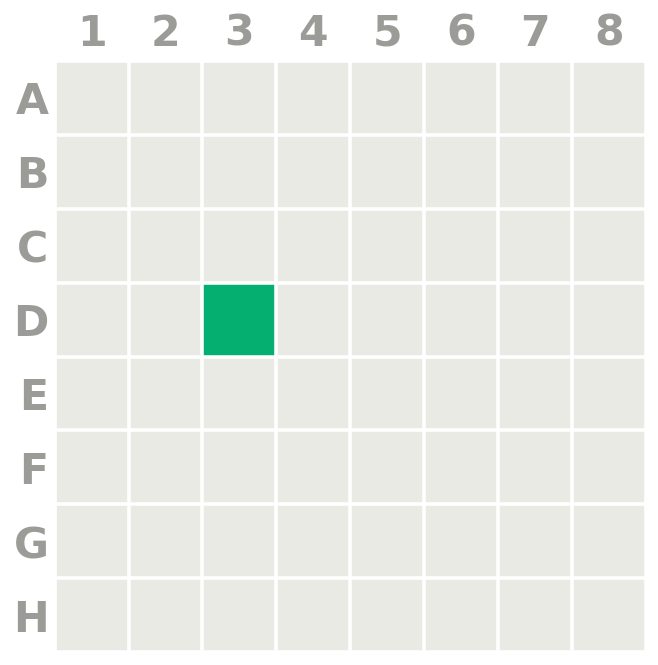

In [53]:
game.state.board[3,2] = true_board.board[3,2]
game
# while not game.is_done():
#     game.next_stage()
#     print(f"Stage {game.stage_index}")
#     display(game)
#     display(heatmap(game.state))
#     break

In [73]:
move, prob = estimate_map_hit_probabilty(game.state)
print(f"MAP move: {move}, Probability: {prob:.4f}")

[[0.0846 0.1186 0.2045 0.1638 0.1685 0.1523 0.1254 0.0792]
 [0.1175 0.1365 0.3216 0.1787 0.1861 0.1832 0.1639 0.1213]
 [0.1351 0.1401 0.4629 0.1727 0.1875 0.1981 0.1837 0.1492]
 [0.2538 0.3924 0.     0.4721 0.3793 0.2881 0.2194 0.1663]
 [0.1493 0.1609 0.5076 0.1764 0.2026 0.2091 0.1978 0.1683]
 [0.1409 0.1672 0.3712 0.1872 0.2035 0.2047 0.1811 0.1526]
 [0.1161 0.1508 0.2615 0.1826 0.1954 0.1852 0.1613 0.1208]
 [0.0854 0.1213 0.1782 0.1685 0.1693 0.1519 0.127  0.0851]]
MAP move: (4, 2), Probability: 0.5076


In [55]:
code_question = spotter.translate(
    question=Question("Is the green ship vertical?"),
    board=game.state,
    history=game.history,
)

In [56]:
print(code_question.fn_str)


def answer(true_board: np.ndarray, partial_board: np.ndarray) -> bool:
    # Identify all tiles belonging to the Green ship (code 2)
    green_positions = np.argwhere(true_board == 2)
    if green_positions.size == 0:
        # No green ship found (shouldn't happen in valid boards); default to No
        return False

    # Extract unique rows and columns occupied by the Green ship
    unique_rows = np.unique(green_positions[:, 0])
    unique_cols = np.unique(green_positions[:, 1])

    # A ship is vertical if all its tiles share the same column
    return unique_cols.size == 1



In [57]:
answer = code_question(true_board=true_board.board, partial_board=game.state.board)
print(answer)

Answer(text='yes', code_question=<battleship.agents.CodeQuestion object at 0x30a9826d0>, _value=True)


In [77]:
def compute_map_move_probability(weighted_boards, state):
    if len(weighted_boards) == 0:
        return None, 0.0, 0.0
    boards, weights = zip(*weighted_boards)
    total_weight = sum(weights)
    posterior = sum(w * (b.board > 0).astype(float) for b, w in zip(boards, weights))
    posterior[state.board != Board.hidden] = 0
    posterior /= total_weight
    flat_idx = int(np.argmax(posterior))
    move_coords = np.unravel_index(flat_idx, posterior.shape)
    move = tuple(move_coords)
    map_prob = posterior[move]
    print(posterior)
    return move, map_prob, total_weight


calculator = EIGCalculator(seed=123, epsilon=0.1)

# Get (board, weight, answer) tuples for code_question
weighted_board_answers = calculator._evaluate_code_question(
    code_question=code_question,
    state=game.state,
    ship_tracker=game.get_reordered_ship_tracker(game.state),
    constraints=[],
)
print(len(weighted_board_answers))

weighted_boards = [(b, w) for (b, w, _) in weighted_board_answers]
move, map_prob, total_weight = compute_map_move_probability(weighted_boards, game.state)
print(f"Probability of hit before question: Move {move}, Probability {map_prob:.4f}, Total Weight {total_weight:.4f}")

# Partition into True and False answers
true_partition = [(board, weight, answer) for board, weight, answer in weighted_board_answers if answer.value is True]
false_partition = [(board, weight, answer) for board, weight, answer in weighted_board_answers if answer.value is False]
print(len(true_partition), len(false_partition))

# For each partition, estimate MAP move and its probability
true_move, true_prob, true_weight = compute_map_move_probability([(b, w) for (b, w, _) in true_partition], game.state)
false_move, false_prob, false_weight = compute_map_move_probability([(b, w) for (b, w, _) in false_partition], game.state)
print(f"True partition: Move {true_move}, Probability {true_prob:.4f}, Weight {true_weight:.4f}")
print(f"False partition: Move {false_move}, Probability {false_prob:.4f}, Weight {false_weight:.4f}")

p_hit_after_question = (true_weight / (true_weight + false_weight)) * true_prob + (false_weight / (true_weight + false_weight)) * false_prob
print(f"Probability of hit after question: {p_hit_after_question:.4f}")

1000
[[0.081 0.117 0.223 0.162 0.158 0.146 0.128 0.081]
 [0.116 0.118 0.303 0.164 0.174 0.176 0.159 0.109]
 [0.119 0.137 0.47  0.153 0.152 0.184 0.184 0.148]
 [0.254 0.397 0.    0.484 0.393 0.307 0.234 0.161]
 [0.147 0.156 0.544 0.169 0.17  0.171 0.201 0.149]
 [0.136 0.158 0.389 0.184 0.206 0.187 0.2   0.139]
 [0.111 0.15  0.285 0.182 0.209 0.169 0.179 0.13 ]
 [0.082 0.125 0.178 0.156 0.168 0.153 0.14  0.085]]
Probability of hit before question: Move (4, 2), Probability 0.5440, Total Weight 1.0000
561 439
[[0.09269162 0.1087344  0.28877005 0.16042781 0.15329768 0.14616756
  0.13547237 0.0802139 ]
 [0.13368984 0.11229947 0.44385027 0.17647059 0.18181818 0.17290553
  0.15686275 0.11051693]
 [0.13012478 0.1372549  0.73796791 0.15686275 0.1426025  0.17647059
  0.18181818 0.14438503]
 [0.1426025  0.14973262 0.         0.15151515 0.15686275 0.18360071
  0.21568627 0.17290553]
 [0.1426025  0.14616756 0.83957219 0.16221034 0.16755793 0.18003565
  0.21746881 0.15151515]
 [0.12121212 0.15151515 

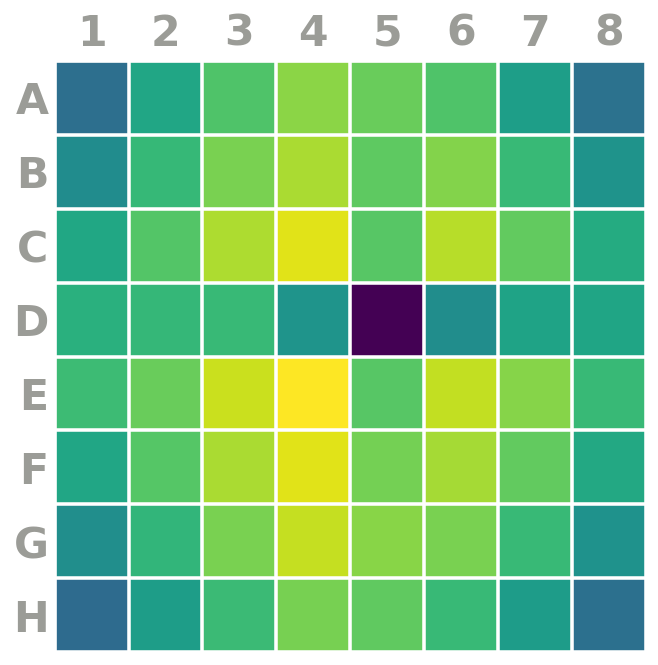

In [13]:
heatmap(game.state, constraints=[(code_question, False)])